In [21]:
#versión de pytorch con cuda
#https://pytorch.org/get-started/locally/
# versión de cuda: nvcc --version
#versión de drivers de cuda: nvidia-smi
#dataset: https://www.kaggle.com/competitions/digit-recognizer/data
# repo base: https://github.com/uygarkurt/ViT-PyTorch/blob/main/vit-implementation.ipynb
import torch
from torch import nn, optim
import pandas  as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm


In [22]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4 # la tasa de aprendizaje
NUM_CLASSES = 10 #Indica la cantidad de objetos de interés (por ejemplo un gato)
PATCH_SIZE= 4 #indica el tamaño de patch solicitado en el paper
IMAGE_SIZE = 28 #Indica el tamaño de la imagen
IN_CHANNELS = 1  #Indica la profundidad o básicamente la cantidad de canales, la parecer no será RGB (3) sino grises
NUM_HEADS = 8  #Indica el attention heads (averiguar que es eso)
DROPOUT=0.001
HIDDEN_DIM=768
ADAM_WEIGHT_DECAY=0 # Valor del optimizador, lo indica el paper
ADAM_BETAS=(0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS=4
EMBED_DIM=(PATCH_SIZE ** 2)*IN_CHANNELS #Obtiene la dimensión de un segmento de la imagen 4x4x1
NUM_PATCHES=(IMAGE_SIZE // PATCH_SIZE) ** 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
print(torch.version.cuda)
print(device)

12.6
cuda:0


In [23]:
class PatchEmbedding(nn.Module):
    """
        Esta clase es la primera etapa del ViT. Su función es:
        Dividir la imagen en parches
        Aplanarlos
        Proyectarlos a embeddings
        Añadir el token [CLS] y los embeddings posicionales
    """
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher= nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=embed_dim , kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2), # Realizamos el aplanamiento
        )
        self.cls_token= nn.Parameter(torch.rand(size=(1,1,embed_dim)), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(size=(1,num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        # los -1 indica que no deseamos modificar la dimensión
        cls_token= self.cls_token.expand(x.shape[0], -1, -1)
        x=self.patcher(x).permute(0,2,1)
        x=torch.cat([cls_token, x], dim=1)
        x=self.position_embedding+x
        x=self.dropout(x)
        return x
model=PatchEmbedding(embed_dim=EMBED_DIM,patch_size=PATCH_SIZE,num_patches=NUM_PATCHES,dropout=DROPOUT,in_channels=IN_CHANNELS).to(device)
#Esto simula 512 imágenes, con 1 canal (escala de grises) y tamaño 28×28.
x=torch.randn(512,1,28,28).to(device)# 50 es el numero de tokens, 16 el valor de los patches
print(model(x).shape)

torch.Size([512, 50, 16])


In [24]:
class ViT(nn.Module):
    def __init__(self, num_patches,img_size,num_classes, patch_size, embed_dim, num_encoders,num_heads, hidden_dim, dropout, activation, in_channels  ):
        super().__init__()
        self.embeddings_block=PatchEmbedding(embed_dim=embed_dim, patch_size=patch_size, num_patches=num_patches, dropout=dropout, in_channels=in_channels)
        encoder_layer=nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks=nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_encoders)
        self.mlp_head=nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes),
        )
    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:,0,:])
        return x
model=ViT(NUM_PATCHES,IMAGE_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x=torch.randn(512,1,28,28).to(device)
print(model(x).shape)

torch.Size([512, 10])


D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\.venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [25]:
train_df=pd.read_csv(r'D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\vit\datasets\digit-recognizer\train.csv')
test_df=pd.read_csv(r"D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\vit\datasets\digit-recognizer\test.csv")
submission_df=pd.read_csv(r"D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\vit\datasets\digit-recognizer\sample_submission.csv")

In [26]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [29]:
train_df, val_df=train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [30]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images=images
        self.labels=labels
        self.indicies=indicies
        self.transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image=self.images[idx].reshape(28,28).astype(np.uint8)
        label=self.labels[idx]
        index=self.indicies[idx]
        image=self.transform(image)
        return  {"image": image, "label": label, "index": index}

In [32]:
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images=images
        self.labels=labels
        self.indicies=indicies
        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image=self.images[idx].reshape(28,28).astype(np.uint8)
        label=self.labels[idx]
        index=self.indicies[idx]
        image=self.transform(image)
        return  {"image": image, "label": label, "index": index}

In [33]:
class MNISTSubmitDataset(Dataset):
    def __init__(self, images,  indicies):
        self.images=images
        self.indicies=indicies
        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image=self.images[idx].reshape(28,28).astype(np.uint8)
        index=self.indicies[idx]
        image=self.transform(image)
        return  {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

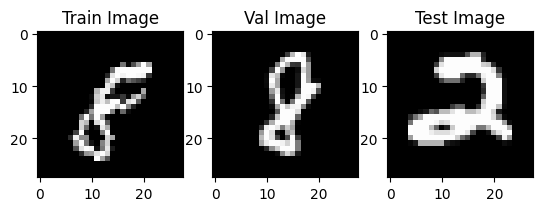

In [34]:
plt.figure()
f,axarr=plt.subplots(1,3)
train_dataset=MNISTTrainDataset(train_df.iloc[:,1:].values.astype(np.uint8), train_df.iloc[:,0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap=plt.get_cmap("gray"))
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset=MNISTValDataset(val_df.iloc[:,1:].values.astype(np.uint8), val_df.iloc[:,0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap=plt.get_cmap("gray"))
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset=MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap=plt.get_cmap("gray"))
axarr[2].set_title("Test Image")
print("-"*30)

In [37]:
train_dataloader=DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader=DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader=DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
start=timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels=[]
    train_preds=[]
    train_running_loss=0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img=img_label["image"].float().to(device)
        label=img_label["label"].type(torch.uint8).to(device)
        y_pred=model(img)
        y_pred_label=torch.argmax(y_pred, dim=1)
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        loss=criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_running_loss+=loss.item()
    train_loss=train_running_loss/(idx+1)
    model.eval()
    val_labels=[]
    val_preds=[]
    val_running_loss=0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img=img_label["image"].float().to(device)
            label=img_label["label"].type(torch.uint8).to(device)
            y_pred=model(img)
            y_pred_label=torch.argmax(y_pred, dim=1)
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            loss=criterion(y_pred, label)
            val_running_loss+=loss.item()
    val_loss=val_running_loss/(idx+1)
    print("-"*30)
    print(f"train loss epoch: {epoch +1}: {train_loss:.4f}")
    print(f"valid loss epoch: {epoch +1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")


100%|██████████| 9/9 [00:00<00:00, 15.81it/s]


------------------------------
train loss epoch: 1: 1.7779
valid loss epoch: 1: 1.5904


  2%|▎         | 1/40 [00:13<09:05, 13.99s/it]

Train Accuracy EPOCH 1: 0.3911
Valid Accuracy EPOCH 1: 0.4969
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.74it/s]


------------------------------
train loss epoch: 2: 1.5717
valid loss epoch: 2: 1.3964


  5%|▌         | 2/40 [00:27<08:45, 13.83s/it]

Train Accuracy EPOCH 2: 0.4975
Valid Accuracy EPOCH 2: 0.5902
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.92it/s]


------------------------------
train loss epoch: 3: 1.4143
valid loss epoch: 3: 1.2561


  8%|▊         | 3/40 [00:41<08:35, 13.93s/it]

Train Accuracy EPOCH 3: 0.5839
Valid Accuracy EPOCH 3: 0.6571
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.73it/s]


------------------------------
train loss epoch: 4: 1.2953
valid loss epoch: 4: 1.1582


 10%|█         | 4/40 [00:55<08:20, 13.90s/it]

Train Accuracy EPOCH 4: 0.6303
Valid Accuracy EPOCH 4: 0.6936
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.68it/s]


------------------------------
train loss epoch: 5: 1.1909
valid loss epoch: 5: 1.0575


 12%|█▎        | 5/40 [01:09<08:10, 14.01s/it]

Train Accuracy EPOCH 5: 0.6669
Valid Accuracy EPOCH 5: 0.7250
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.55it/s]


------------------------------
train loss epoch: 6: 1.0823
valid loss epoch: 6: 0.9635


 15%|█▌        | 6/40 [01:24<07:58, 14.09s/it]

Train Accuracy EPOCH 6: 0.7099
Valid Accuracy EPOCH 6: 0.7607
------------------------------


100%|██████████| 9/9 [00:00<00:00, 14.65it/s]


------------------------------
train loss epoch: 7: 1.0168
valid loss epoch: 7: 0.8856


 18%|█▊        | 7/40 [01:38<07:43, 14.05s/it]

Train Accuracy EPOCH 7: 0.7320
Valid Accuracy EPOCH 7: 0.7783
------------------------------


100%|██████████| 9/9 [00:00<00:00, 14.85it/s]


------------------------------
train loss epoch: 8: 0.9328
valid loss epoch: 8: 0.8082


 20%|██        | 8/40 [01:52<07:31, 14.12s/it]

Train Accuracy EPOCH 8: 0.7583
Valid Accuracy EPOCH 8: 0.8131
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


------------------------------
train loss epoch: 9: 0.8633
valid loss epoch: 9: 0.7603


 22%|██▎       | 9/40 [02:06<07:15, 14.06s/it]

Train Accuracy EPOCH 9: 0.7822
Valid Accuracy EPOCH 9: 0.8267
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.37it/s]


------------------------------
train loss epoch: 10: 0.8155
valid loss epoch: 10: 0.7004


 25%|██▌       | 10/40 [02:20<07:00, 14.01s/it]

Train Accuracy EPOCH 10: 0.7924
Valid Accuracy EPOCH 10: 0.8469
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.75it/s]


------------------------------
train loss epoch: 11: 0.7604
valid loss epoch: 11: 0.6609


 28%|██▊       | 11/40 [02:34<06:46, 14.00s/it]

Train Accuracy EPOCH 11: 0.8107
Valid Accuracy EPOCH 11: 0.8529
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.28it/s]


------------------------------
train loss epoch: 12: 0.7078
valid loss epoch: 12: 0.6060


 30%|███       | 12/40 [02:48<06:31, 13.98s/it]

Train Accuracy EPOCH 12: 0.8258
Valid Accuracy EPOCH 12: 0.8652
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.62it/s]


------------------------------
train loss epoch: 13: 0.6751
valid loss epoch: 13: 0.5639


 32%|███▎      | 13/40 [03:02<06:18, 14.01s/it]

Train Accuracy EPOCH 13: 0.8325
Valid Accuracy EPOCH 13: 0.8793
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.88it/s]


------------------------------
train loss epoch: 14: 0.6265
valid loss epoch: 14: 0.5292


 35%|███▌      | 14/40 [03:16<06:05, 14.05s/it]

Train Accuracy EPOCH 14: 0.8461
Valid Accuracy EPOCH 14: 0.8874
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.93it/s]


------------------------------
train loss epoch: 15: 0.5887
valid loss epoch: 15: 0.4870


 38%|███▊      | 15/40 [03:30<05:50, 14.01s/it]

Train Accuracy EPOCH 15: 0.8566
Valid Accuracy EPOCH 15: 0.8950
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.95it/s]


------------------------------
train loss epoch: 16: 0.5711
valid loss epoch: 16: 0.4676


 40%|████      | 16/40 [03:44<05:35, 13.96s/it]

Train Accuracy EPOCH 16: 0.8590
Valid Accuracy EPOCH 16: 0.9014
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.81it/s]


------------------------------
train loss epoch: 17: 0.5321
valid loss epoch: 17: 0.4803


 42%|████▎     | 17/40 [03:57<05:19, 13.88s/it]

Train Accuracy EPOCH 17: 0.8689
Valid Accuracy EPOCH 17: 0.8843
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.15it/s]


------------------------------
train loss epoch: 18: 0.5074
valid loss epoch: 18: 0.4194


 45%|████▌     | 18/40 [04:11<05:07, 13.98s/it]

Train Accuracy EPOCH 18: 0.8762
Valid Accuracy EPOCH 18: 0.9124
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.01it/s]


------------------------------
train loss epoch: 19: 0.4877
valid loss epoch: 19: 0.4299


 48%|████▊     | 19/40 [04:25<04:50, 13.86s/it]

Train Accuracy EPOCH 19: 0.8779
Valid Accuracy EPOCH 19: 0.9024
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.95it/s]


------------------------------
train loss epoch: 20: 0.4651
valid loss epoch: 20: 0.3834


 50%|█████     | 20/40 [04:39<04:37, 13.87s/it]

Train Accuracy EPOCH 20: 0.8816
Valid Accuracy EPOCH 20: 0.9140
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.07it/s]


------------------------------
train loss epoch: 21: 0.4490
valid loss epoch: 21: 0.3756


 52%|█████▎    | 21/40 [04:53<04:22, 13.81s/it]

Train Accuracy EPOCH 21: 0.8852
Valid Accuracy EPOCH 21: 0.9155
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.84it/s]


------------------------------
train loss epoch: 22: 0.4288
valid loss epoch: 22: 0.3459


 55%|█████▌    | 22/40 [05:06<04:07, 13.74s/it]

Train Accuracy EPOCH 22: 0.8908
Valid Accuracy EPOCH 22: 0.9243
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.16it/s]


------------------------------
train loss epoch: 23: 0.4144
valid loss epoch: 23: 0.3194


 57%|█████▊    | 23/40 [05:20<03:53, 13.74s/it]

Train Accuracy EPOCH 23: 0.8931
Valid Accuracy EPOCH 23: 0.9262
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.16it/s]


------------------------------
train loss epoch: 24: 0.3975
valid loss epoch: 24: 0.3179


 60%|██████    | 24/40 [05:33<03:38, 13.67s/it]

Train Accuracy EPOCH 24: 0.8954
Valid Accuracy EPOCH 24: 0.9269
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.35it/s]


------------------------------
train loss epoch: 25: 0.3882
valid loss epoch: 25: 0.3105


 62%|██████▎   | 25/40 [05:47<03:25, 13.71s/it]

Train Accuracy EPOCH 25: 0.8993
Valid Accuracy EPOCH 25: 0.9274
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


------------------------------
train loss epoch: 26: 0.3761
valid loss epoch: 26: 0.3297


 65%|██████▌   | 26/40 [06:01<03:11, 13.68s/it]

Train Accuracy EPOCH 26: 0.9002
Valid Accuracy EPOCH 26: 0.9186
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.09it/s]


------------------------------
train loss epoch: 27: 0.3621
valid loss epoch: 27: 0.2931


 68%|██████▊   | 27/40 [06:14<02:57, 13.64s/it]

Train Accuracy EPOCH 27: 0.9048
Valid Accuracy EPOCH 27: 0.9293
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.11it/s]


------------------------------
train loss epoch: 28: 0.3551
valid loss epoch: 28: 0.2842


 70%|███████   | 28/40 [06:28<02:43, 13.65s/it]

Train Accuracy EPOCH 28: 0.9045
Valid Accuracy EPOCH 28: 0.9283
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.25it/s]


------------------------------
train loss epoch: 29: 0.3485
valid loss epoch: 29: 0.2718


 72%|███████▎  | 29/40 [06:42<02:29, 13.63s/it]

Train Accuracy EPOCH 29: 0.9048
Valid Accuracy EPOCH 29: 0.9340
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.99it/s]


------------------------------
train loss epoch: 30: 0.3340
valid loss epoch: 30: 0.2707


 75%|███████▌  | 30/40 [06:55<02:15, 13.60s/it]

Train Accuracy EPOCH 30: 0.9097
Valid Accuracy EPOCH 30: 0.9374
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.87it/s]


------------------------------
train loss epoch: 31: 0.3217
valid loss epoch: 31: 0.2724


 78%|███████▊  | 31/40 [07:09<02:02, 13.62s/it]

Train Accuracy EPOCH 31: 0.9128
Valid Accuracy EPOCH 31: 0.9307
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.20it/s]


------------------------------
train loss epoch: 32: 0.3192
valid loss epoch: 32: 0.2458


 80%|████████  | 32/40 [07:22<01:48, 13.60s/it]

Train Accuracy EPOCH 32: 0.9129
Valid Accuracy EPOCH 32: 0.9355
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.13it/s]


------------------------------
train loss epoch: 33: 0.3055
valid loss epoch: 33: 0.2528


 82%|████████▎ | 33/40 [07:36<01:35, 13.62s/it]

Train Accuracy EPOCH 33: 0.9161
Valid Accuracy EPOCH 33: 0.9417
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.01it/s]


------------------------------
train loss epoch: 34: 0.2978
valid loss epoch: 34: 0.2585


 85%|████████▌ | 34/40 [07:49<01:21, 13.58s/it]

Train Accuracy EPOCH 34: 0.9173
Valid Accuracy EPOCH 34: 0.9319
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.32it/s]


------------------------------
train loss epoch: 35: 0.2977
valid loss epoch: 35: 0.2371


 88%|████████▊ | 35/40 [08:03<01:07, 13.57s/it]

Train Accuracy EPOCH 35: 0.9165
Valid Accuracy EPOCH 35: 0.9340
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.06it/s]


------------------------------
train loss epoch: 36: 0.2907
valid loss epoch: 36: 0.2334


 90%|█████████ | 36/40 [08:17<00:54, 13.64s/it]

Train Accuracy EPOCH 36: 0.9185
Valid Accuracy EPOCH 36: 0.9412
------------------------------


100%|██████████| 9/9 [00:00<00:00, 16.13it/s]


------------------------------
train loss epoch: 37: 0.2877
valid loss epoch: 37: 0.2306


 92%|█████████▎| 37/40 [08:30<00:40, 13.60s/it]

Train Accuracy EPOCH 37: 0.9194
Valid Accuracy EPOCH 37: 0.9445
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.67it/s]


------------------------------
train loss epoch: 38: 0.2812
valid loss epoch: 38: 0.2372


 95%|█████████▌| 38/40 [08:45<00:27, 13.88s/it]

Train Accuracy EPOCH 38: 0.9203
Valid Accuracy EPOCH 38: 0.9398
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.75it/s]


------------------------------
train loss epoch: 39: 0.2683
valid loss epoch: 39: 0.2260


 98%|█████████▊| 39/40 [08:59<00:13, 13.81s/it]

Train Accuracy EPOCH 39: 0.9243
Valid Accuracy EPOCH 39: 0.9383
------------------------------


100%|██████████| 9/9 [00:00<00:00, 13.66it/s]


------------------------------
train loss epoch: 40: 0.2635
valid loss epoch: 40: 0.2059


100%|██████████| 40/40 [09:13<00:00, 13.84s/it]

Train Accuracy EPOCH 40: 0.9244
Valid Accuracy EPOCH 40: 0.9460
------------------------------
Training Time: 553.79s


In [43]:
torch.cuda.empty_cache() #libera el espacio en nuestro gpu

In [44]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:04<00:00, 11.78it/s]


<Figure size 640x480 with 0 Axes>

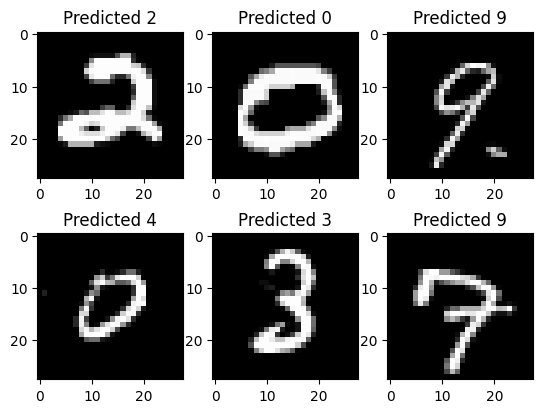

In [45]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [46]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3
